# EDA 

### Loading

In [2]:
# Imports 
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import torch
import umap
import hdbscan
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns



/home/ubuntu/dsan6000/Topic_Modeling_on_Amazon_Reviews-/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Using the clean data and embedding model to create BERTopic model

# Loading the clean df and gettign EDA viz  
df_path = '../cleaned_data/amazon_clean/amazon_reviewsAll_Beauty.jsonl'

#Reading to get the first rows
records = []
with open(df_path, 'r') as f:
    for i, line in enumerate(f):
        if i < 5:  # Read first 5 records
            records.append(json.loads(line))
        else:
            break

#Structure of the df 
print("Sample records:")
for i, record in enumerate(records):
    print(f"\nRecord {i+1}:")
    print(json.dumps(record, indent=2))

# Load all data into DataFrame
df_reviews = pd.read_json(df_path, lines=True)
print(f"\n\nDataset shape: {df_reviews.shape}")
print(f"\nColumn names: {df_reviews.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_reviews.head())
print(f"\nData types:\n{df_reviews.dtypes}")


Sample records:

Record 1:
{
  "rating": 5.0,
  "title": "such a lovely scent but not overpowering",
  "text": "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",
  "images": [],
  "asin": "B00YQ6X8EO",
  "parent_asin": "B00YQ6X8EO",
  "user_id": "AGKHLEW2SOWHNMFQIJGBECAF7INQ",
  "timestamp": 1588687728923,
  "helpful_vote": 0,
  "verified_purchase": true
}

Record 2:
{
  "rating": 4.0,
  "title": "works great but smells a little weird",
  "text": "This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)",
  "images": [],
  "asin": "B081TJ8YS3",
  "parent_asin": 

## Statistics & Distribution

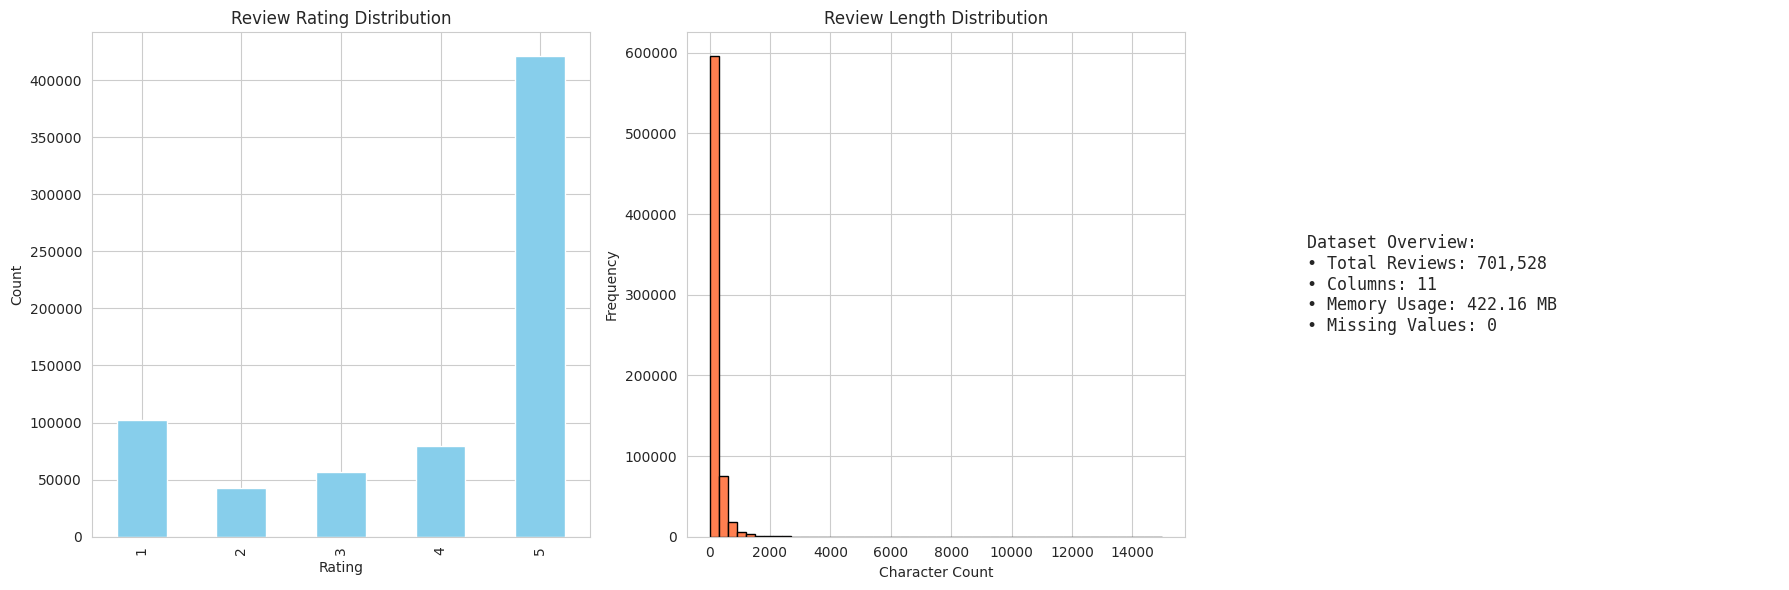

In [16]:
#EDA  getting basic stats & distribution of the data.  

# Style & panel 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 6)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Rating Distribution -->  seeing ig there are  more postivie or negative ratings. 
if 'rating' in df_reviews.columns:
    df_reviews['rating'].value_counts().sort_index().plot(
        kind='bar', ax=axes[0], color='skyblue'
    )
    axes[0].set_title('Review Rating Distribution')
    axes[0].set_xlabel('Rating')
    axes[0].set_ylabel('Count')

#gettng the length of the reviews adn whehter most of them are long or short
text_col = 'review_body' if 'review_body' in df_reviews.columns else 'text'
df_reviews['review_length'] = df_reviews[text_col].str.len()

axes[1].hist(df_reviews['review_length'], bins=50, color='coral', edgecolor='black')
axes[1].set_title('Review Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

# Overall stats with missing vals. 
axes[2].axis('off')
stats_text = f"""
Dataset Overview:
• Total Reviews: {len(df_reviews):,}
• Columns: {len(df_reviews.columns)}
• Memory Usage: {df_reviews.memory_usage(deep=True).sum() / 1024**2:.2f} MB
• Missing Values: {df_reviews.isnull().sum().sum()}
"""
axes[2].text(0.05, 0.5, stats_text, fontsize=12, verticalalignment='center', family='monospace')

plt.tight_layout()
plt.show()


In [19]:
# Saving the stats and distribution. 
fig.savefig("../data/eda_results/eda_stats_dist.png", dpi=300, bbox_inches='tight')


In [13]:

# Making the plots above interactive so they are nice for presentation
# Visualization 2: Interactive visualizations with Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Rating distribution first 
if 'rating' in df_reviews.columns:
    rating_counts = df_reviews['rating'].value_counts().sort_index()
    fig1 = px.bar(
        x=rating_counts.index,
        y=rating_counts.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Interactive Rating Distribution',
        color=rating_counts.values,
        color_continuous_scale='Viridis'
    )

    # Adding the Data Overview 

    # ---- Add dataset overview text annotation ----
    stats_text = (
    f"Dataset Overview:<br>"
    f"Total Reviews: {len(df_reviews):,}<br>"
    f"Columns: {len(df_reviews.columns)}<br>"
    f"Memory Usage: {df_reviews.memory_usage(deep=True).sum() / 1024**2:.2f} MB<br>"
    f"Missing Values: {df_reviews.isnull().sum().sum()}"
)

    fig1.add_annotation(
    text=stats_text,
    xref="paper",
    yref="paper",
    x=1.15,    # Restructuring its in a weird place
    y=-0.27,
    showarrow=False,
    font=dict(size=9, family="monospace"),
    align="left",
    bordercolor="black",
    borderwidth=1,
    bgcolor="white",
    opacity=0.8
)

    fig1.show()


#  text statts
if 'review_body' in df_reviews.columns or 'text' in df_reviews.columns:
    text_col = 'review_body' if 'review_body' in df_reviews.columns else 'text'
    
    # Word count per review
    df_reviews['word_count'] = df_reviews[text_col].str.split().str.len()
    
    fig2 = px.histogram(
        df_reviews,
        x='word_count',
        nbins=50,
        title='Word Count Distribution in Reviews',
        labels={'word_count': 'Number of Words'},
        color_discrete_sequence=['indianred']
    )
    fig2.update_xaxes(title_text="Number of Words")
    fig2.update_yaxes(title_text="Frequency")
    fig2.show()

In [14]:
# Saving them 
fig1.write_html("../data/eda_results/plotly_rating_dist.html")
fig2.write_html("../data/eda_results/plotly_text_dist.html")


In [16]:
# Reviews per verified purchases 

fig = px.histogram(df_reviews, x="rating", color="verified_purchase",
                   barmode="group",
                   title="Ratings by Verified Purchase Status")
fig.show()

fig.write_html("../data/eda_results/plotly_verified_purchase.html")


In [23]:
#Avg rating trend 

#converting timestamp & filtering 
df_reviews["date"] = pd.to_datetime(df_reviews["timestamp"], unit="ms")
df_reviews["year"] = df_reviews["date"].dt.year
df_reviews["month"] = df_reviews["date"].dt.to_period("M").dt.to_timestamp()

df_2023 = df_reviews[df_reviews["year"] == 2023].copy()

# Stats by month
monthly_2023 = df_2023.groupby("month").agg(
    review_count=("rating", "count"),
    avg_rating=("rating", "mean")
).reset_index()

monthly_2023["month_name"] = monthly_2023["month"].dt.strftime("%b")

# Creating the dual-axis plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=monthly_2023["month_name"],
        y=monthly_2023["review_count"],
        mode="lines+markers",
        name="Review Count",
        line=dict(color="royalblue", width=3)
    )
)

# Avg rating 
fig.add_trace(
    go.Scatter(
        x=monthly_2023["month_name"],
        y=monthly_2023["avg_rating"],
        mode="lines+markers",
        name="Average Rating",
        yaxis="y2",
        line=dict(color="orange", width=3)
    )
)

fig.update_layout(
    title="Monthly Review Count and Average Rating 2023",
    xaxis=dict(title="Month"),
    
    yaxis=dict(
        title="Review Count",
        side="left",
        range=[0, monthly_2023["review_count"].max() * 1.2]
    ),
    
    yaxis2=dict(
        title="Average Rating",
        overlaying="y",
        side="right",
        range=[df_reviews["rating"].min() - 0.2, df_reviews["rating"].max() + 0.2]
    ),
    
    legend=dict(x=0.01, y=1),
    template="plotly_white",
    width=950,
    height=500
)

fig.show()



In [24]:

# Save interactive HTML
fig.write_html("../data/eda_results/interactive_reviews_ratings_2023.html")

